## NAGASAKI Group Project 

- Notebook to perform clustering on the Landsat Tile.

In [1]:
import rasterio
import earthpy.spatial as es
import os, sys
from glob import glob
import numpy as np
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import geometry

In [2]:
def histogram_stretch(img, min_vals = None, max_vals = 99):
    """
    Performs a histogram_stretch on an image. DO NOT use this for analytical workflows - 
    this should only be used to improve image visualization
    
    img: an unmasked 3D raster 
    
    min_vals: percentile that you wish to crop to
        will be np.zeros by default
    max_vals: percentile that you wish to crop to
        will be np.nanpercentile(img, 99) by default # crops to 99th percentile
    """
    if img.ndim != 3:
        print("ValueError: Your raster must have three dimensions.")
        return
    
    # This returns the max_valth percentile
    max_vals = np.nanpercentile(img, max_vals, axis = (1,2)).reshape(img.shape[0],1,1) 
    # min_vals = np.nanmin(tcc_toa, axis = (1,2)).reshape(3,1,1) # Use this to stretch to minimum values
    if min_vals is not None:
        min_vals = np.nanpercentile(img, min_vals, axis = (1,2)).reshape(img.shape[0],1,1)
    else:
        min_vals = np.zeros(img.shape[0]).reshape(img.shape[0],1,1)
    
    # Perform normalization
    img_stretched = (img - min_vals) / (max_vals - min_vals)
    # print('.....', type(min_vals), min_vals)
    # print('.....', type(max_vals), max_vals)
    
    # Clip values above 1
    img_stretched[img_stretched > 1] = 1
    
    return img_stretched

In [3]:
band_paths = glob(
    os.path.join(
        '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1',
        '*B*[0-9].TIF'
    )
)

band_paths = sorted(band_paths)
band_paths

['../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B1.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B2.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B3.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B4.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B5.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B6.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B7.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_ST_B10.TIF']

In [4]:
band_paths = glob(
    os.path.join(
        '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1',
        '*B*[0-9].TIF'
    )
)

band_paths = sorted(band_paths)

# ...finds QA PIXEL band
qa_path = glob(
    os.path.join(
        '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1',
        "*QA_PIXEL.TIF"
    )
)

qa_path = sorted(qa_path)

paths_to_crop = band_paths + qa_path
paths_to_crop

['../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B1.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B2.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B3.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B4.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B5.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B6.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B7.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_ST_B10.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2S

In [5]:
img_stack, metadata = es.stack(band_paths=band_paths, 
                               out_path='../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/nagasaki_img_stacked_L9.tif')
type(img_stack), type(metadata)

(numpy.ndarray, rasterio.profiles.Profile)

In [6]:
metadata["crs"], metadata["count"]

(CRS.from_epsg(32652), 8)

In [7]:
with rasterio.open('../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/nagasaki_img_stacked_L9.tif') as src:
    bounds = src.bounds
    profile = src.profile
    src.close()
    
print(bounds)
print(profile)

BoundingBox(left=479985.0, bottom=3554385.0, right=708615.0, top=3787215.0)
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7621, 'height': 7761, 'count': 8, 'crs': CRS.from_epsg(32652), 'transform': Affine(30.0, 0.0, 479985.0,
       0.0, -30.0, 3787215.0), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}


In [8]:
dataset = rasterio.open('../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/nagasaki_img_stacked_L9.tif')
type(dataset)

rasterio.io.DatasetReader

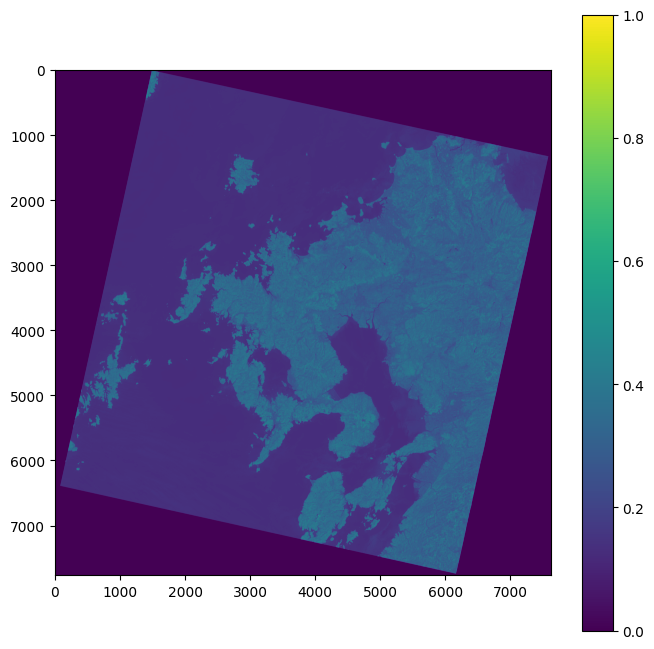

In [9]:
from rasterio.plot import adjust_band

fig, ax = plt.subplots(figsize=(8, 8))
obj = ax.imshow(adjust_band(dataset.read(5)))
fig.colorbar(obj, ax=ax, shrink=1);

In [10]:
img_stack.shape

(8, 7761, 7621)

CPU times: user 1.06 s, sys: 1 s, total: 2.06 s
Wall time: 2.71 s


Text(0.5, 1.0, 'Applying a bounding box to crop the investigated area of Nagasaki.')

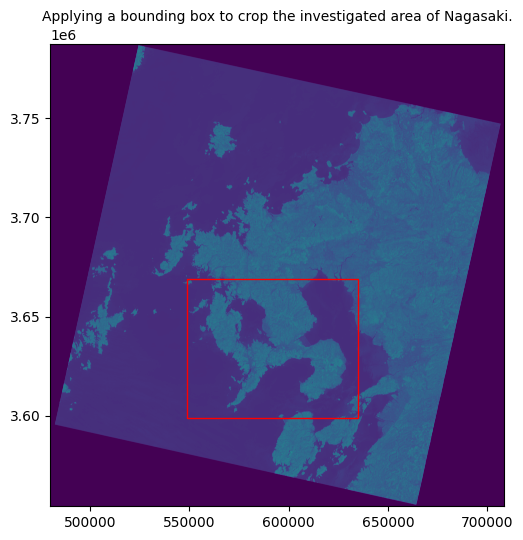

In [11]:
%%time

scaled_img_stack = img_stack * 0.0000275 - 0.2

target_bounding_img_shp = geometry.box(549000, 3599000, 635000, 3669000)

# creat a geopands df
df = gpd.GeoDataFrame({"id":1, 
                       "geometry":[target_bounding_img_shp]})

fig, ax = plt.subplots(figsize = (6, 6))

# remember to use transform argument to set the raster image to coordinates
rasterio.plot.show(scaled_img_stack[4], ax = ax, transform = profile['transform'])
df.plot(color = 'none', edgecolor = 'red', ax = ax)

ax.set_title("Applying a bounding box to crop the investigated area of Nagasaki.", fontsize=10)

In [12]:
band_paths_ = es.crop_all(
    raster_paths=paths_to_crop,
    output_dir='../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1',
    geoms=[target_bounding_img_shp],
    overwrite=True
)

band_paths_

['../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B1_crop.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B2_crop.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B3_crop.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B4_crop.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B5_crop.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B6_crop.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_SR_B7_crop.TIF',
 '../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/LC09_L2SP_113037_20230510_20230512_02_T1_ST_B10_crop.TIF',
 '../data/Raster_data/LC09_L2SP

In [13]:
# stack the cropped data and 
cropped_img_stack, cropped_img_metadata = es.stack(band_paths=band_paths_[:-1],
                                                   out_path='../data/Raster_data/LC09_L2SP_113037_20230510_20230512_02_T1/nagasaki_cropped_img_stacked_L9.tif')

type(cropped_img_stack), type(cropped_img_metadata)

(numpy.ndarray, rasterio.profiles.Profile)

In [14]:
cropped_img_stack.shape

(8, 2334, 2868)

In [15]:
band_mapping = {
    "B1": "Visible Coastal Aerosol",
    "B2": "Visible Blue",
    "B3": "Visible Green",
    "B4": "Red",
    "B5": "Near-Infrared",
    "B6": "SWIR 1",
    "B7": "SWIR 2",
    "B7": "SWIR 2",
    "B10": "TMIR"
    }

band_mapping

{'B1': 'Visible Coastal Aerosol',
 'B2': 'Visible Blue',
 'B3': 'Visible Green',
 'B4': 'Red',
 'B5': 'Near-Infrared',
 'B6': 'SWIR 1',
 'B7': 'SWIR 2',
 'B10': 'TMIR'}

In [16]:
green_band = cropped_img_stack[2]
nir_band = cropped_img_stack[4]
red_band = cropped_img_stack[3]

ndwi = (green_band.astype(float) - nir_band.astype(float)) / (green_band.astype(float) + nir_band.astype(float))
ndvi = (nir_band.astype(float) - red_band.astype(float)) / (red_band.astype(float) + nir_band.astype(float))

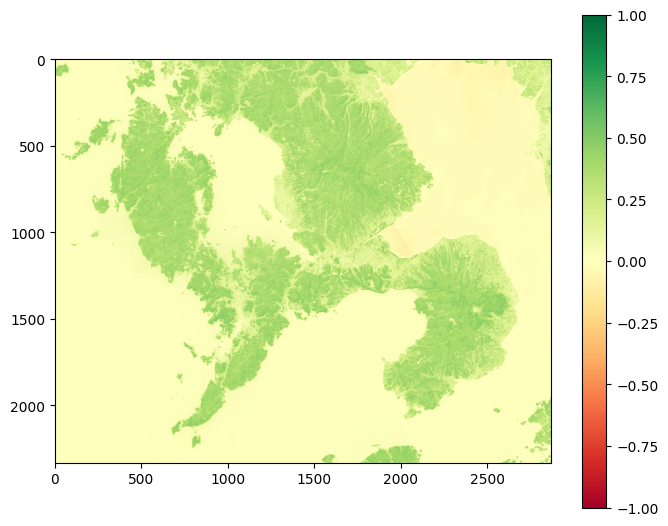

In [17]:
from rasterio.plot import adjust_band

# %matplotlib qt

fig, ax = plt.subplots(figsize=(8,8))
obj = ax.imshow(ndvi, cmap='RdYlGn')
fig.colorbar(obj, ax=ax, shrink=0.8);

In [18]:
band_mapping

{'B1': 'Visible Coastal Aerosol',
 'B2': 'Visible Blue',
 'B3': 'Visible Green',
 'B4': 'Red',
 'B5': 'Near-Infrared',
 'B6': 'SWIR 1',
 'B7': 'SWIR 2',
 'B10': 'TMIR'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

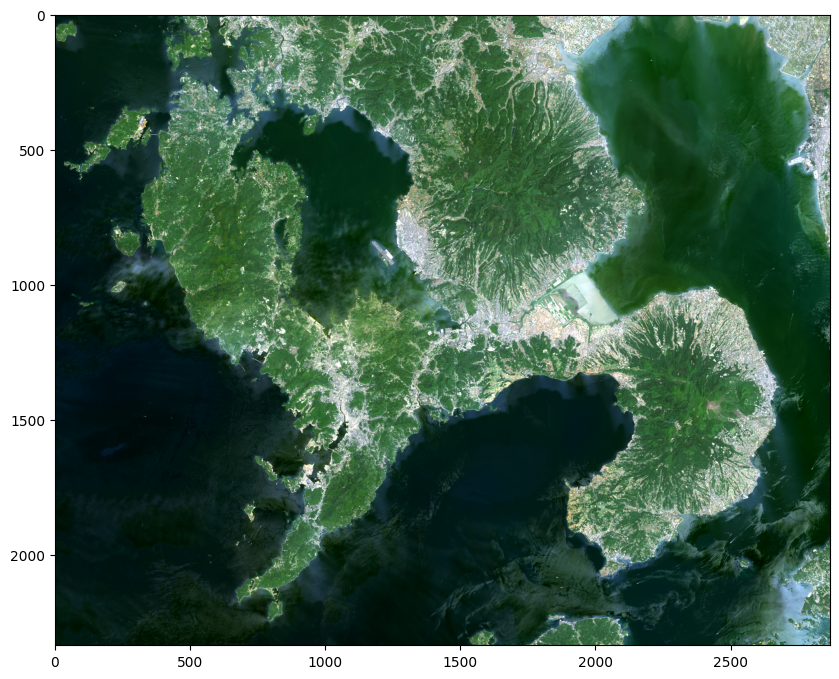

In [19]:
scaled_cropped_img_stack = (cropped_img_stack * 0.0000275 - 0.2)

fig, ax = plt.subplots(figsize = (10,10))

show(histogram_stretch(scaled_cropped_img_stack[[3,2,1],...]), ax = ax)

# false composite
# show(histogram_stretch(scaled_cropped_img_stack[[6,5,3],...]), ax = ax)

In [20]:
def reshape_as_image(arr):
    """Returns the source array reshaped into the order
    expected by image processing and visualization software
    (matplotlib, scikit-image, etc)
    by swapping the axes order from (bands, rows, columns)
    to (rows, columns, bands)

    Parameters
    ----------
    arr : array-like of shape (bands, rows, columns)
        image to reshape
    """
    # swap the axes order from (bands, rows, columns) to (rows, columns, bands)
    im = np.ma.transpose(arr, [1, 2, 0])
    return im

In [21]:
reshaped_scaled_cropped_img_stack = reshape_as_image(scaled_cropped_img_stack)
reshaped_scaled_cropped_img_stack.shape

(2334, 2868, 8)

In [22]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors

In [23]:
dataset_2013 = rasterio.open("../data/Raster_data/nagasaki_L9_2013_cropped_stacked.tif")
dataset_2013

<open DatasetReader name='../data/Raster_data/nagasaki_L9_2013_cropped_stacked.tif' mode='r'>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Axes: >

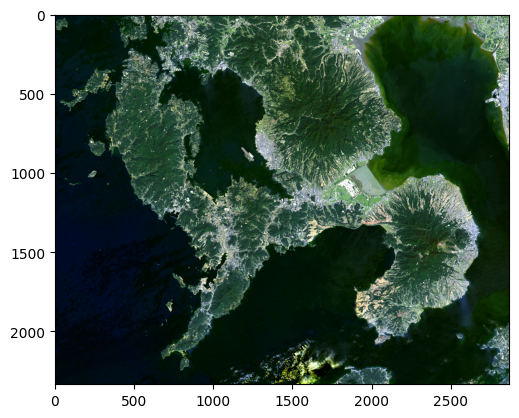

In [24]:
red_band_2013 = dataset_2013.read(4)
green_band_2013 = dataset_2013.read(3)
blue_band_2013 = dataset_2013.read(1)
nir_band_2013 = dataset_2013.read(5)

fig, ax = plt.subplots()

stretched = histogram_stretch(np.array([red_band_2013, green_band_2013, blue_band_2013]) * 0.0000275 - 0.2)

show(stretched, ax=ax)

In [25]:
ndvi_2013 = (nir_band_2013.astype(float) - red_band_2013.astype(float)) / (red_band_2013.astype(float) + nir_band_2013.astype(float))

In [26]:
stretched.shape

(3, 2334, 2868)

### 2013 Clustering

/Users/ds423/miniconda3/envs/e-data/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


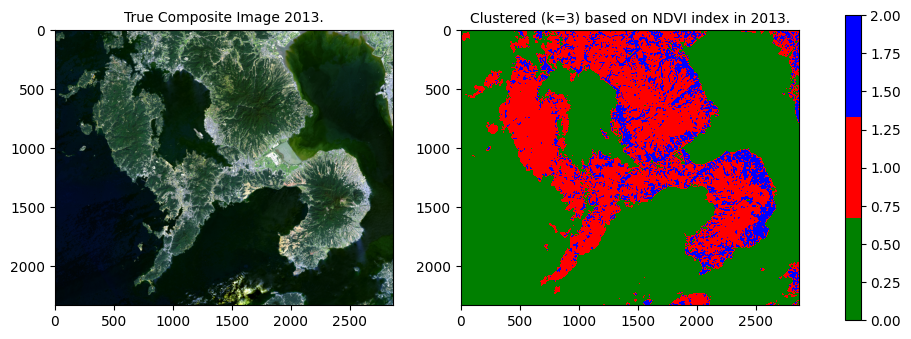

In [27]:
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['g', 'r', 'b'])

bands, rows, cols = stretched.shape

k = 3 # num of clusters
kmeans_predictions = KMeans(n_clusters=k, random_state=0).fit(ndvi_2013.reshape(-1, 1))
kmeans_predictions_2d = kmeans_predictions.labels_.reshape(rows, cols)

# Now show the classmap next to the image
fig, axs = plt.subplots(1, 2, figsize=(12, 12))

show(stretched, ax=axs[0])
axs[0].set_title(f"True Composite Image 2013.", fontsize=10)

obj = axs[1].imshow(kmeans_predictions_2d, cmap=cmap)
axs[1].set_title(f"Clustered (k={k}) based on NDVI index in 2013.", fontsize=10)

fig.colorbar(obj, ax=axs, shrink=0.33);

Text(0.5, 1.0, 'Raw NDVI Distribution 2013.')

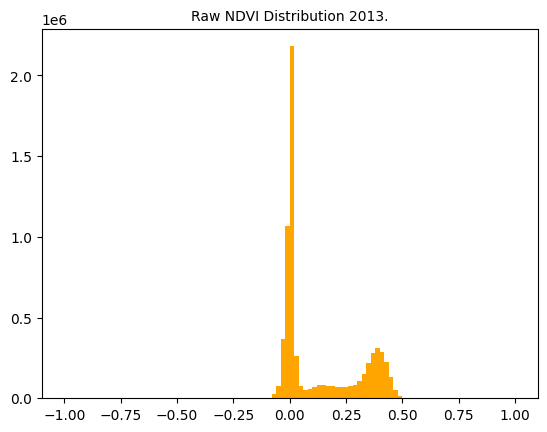

In [28]:
plt.hist(ndvi.ravel(), bins=100, color='orange');
plt.title("Raw NDVI Distribution 2013.", fontsize=10)

/Users/ds423/miniconda3/envs/e-data/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


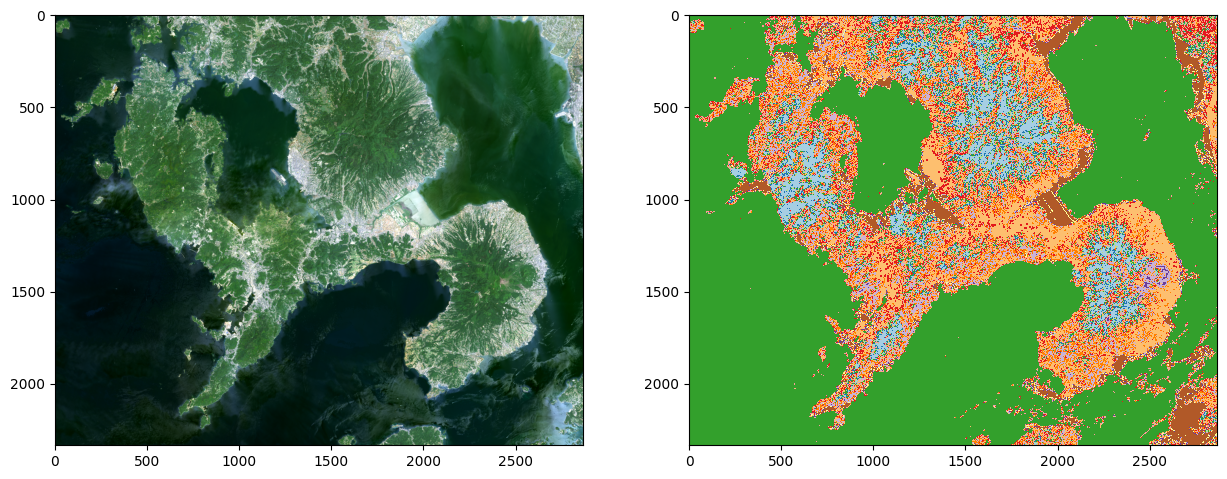

In [29]:
from sklearn.cluster import KMeans

bands, rows, cols = scaled_cropped_img_stack.shape

k = 5 # num of clusters

kmeans_predictions = KMeans(n_clusters=k, random_state=42).fit(reshaped_scaled_cropped_img_stack.reshape(-1, 8))

kmeans_predictions_2d = kmeans_predictions.labels_.reshape(rows, cols)

# Now show the classmap next to the image
fig, axs = plt.subplots(1,2,figsize=(15,8))

img_stretched = color_stretch(reshaped_scaled_cropped_img_stack, [3, 2, 1])
# axs[0].imshow(reshaped_scaled_cropped_img_stack)
show(histogram_stretch(scaled_cropped_img_stack[[3,2,1],...]), ax = axs[0])

axs[1].imshow(kmeans_predictions_2d, cmap='Paired')

### Present Clustering (2023)

/Users/ds423/miniconda3/envs/e-data/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


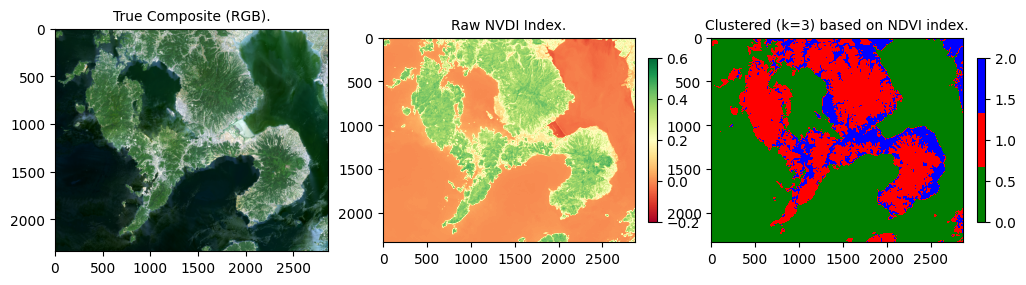

In [30]:
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap

# Now show the classmap next to the image
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,12))

bands, rows, cols = scaled_cropped_img_stack.shape

cmap = ListedColormap(['g', 'r', 'b'])

k = 3 # num of clusters

kmeans_predictions = KMeans(n_clusters=k, random_state=0).fit(ndwi.reshape(-1, 1))
kmeans_predictions_2d = kmeans_predictions.labels_.reshape(rows, cols)

show(histogram_stretch(scaled_cropped_img_stack[[3,2,1],...]), ax = axs[0])
obj1 = axs[1].imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.6)
obj2 = axs[2].imshow(kmeans_predictions_2d, cmap=cmap)

axs[0].set_title("True Composite (RGB).", fontsize=10)
axs[1].set_title(f"Raw NVDI Index.", fontsize=10)
axs[2].set_title(f"Clustered (k={k}) based on NDVI index.", fontsize=10)

fig.colorbar(obj1, ax=axs[1], fraction=0.03);
fig.colorbar(obj2, ax=axs[2], fraction=0.03);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'True Composite (RGB) L9 Landsat 2023.')

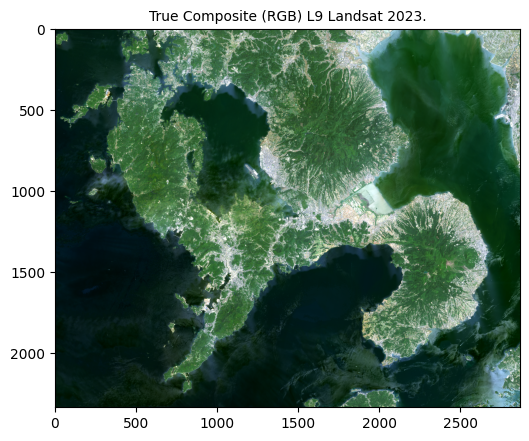

In [31]:
# Tru Composite Plot.
fig, ax = plt.subplots(figsize=(6, 6))

# plot 
show(histogram_stretch(scaled_cropped_img_stack[[3,2,1],...]), ax = ax)
ax.set_title("True Composite (RGB) L9 Landsat 2023.", fontsize=10)


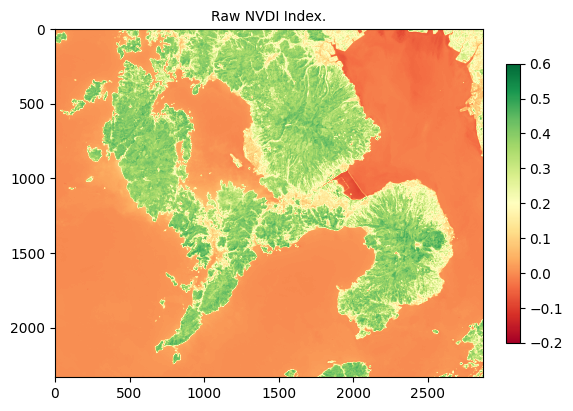

In [32]:
# NDVI Plot.
fig, ax = plt.subplots(figsize=(6, 6))
obj = ax.imshow(ndvi, cmap='RdYlGn', vmin=-0.2, vmax=0.6)

ax.set_title(f"Raw NVDI Index.", fontsize=10)
fig.colorbar(obj, ax=ax, fraction=0.03);

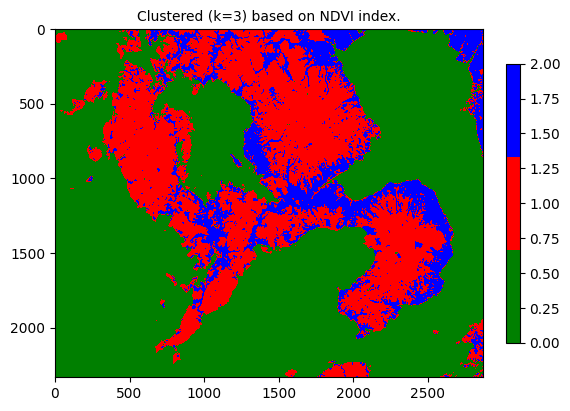

In [33]:
from matplotlib.colors import ListedColormap

# Now show the classmap next to the image
fig, ax = plt.subplots(figsize=(6, 6))

cmap = ListedColormap(['g', 'r', 'b'])
k = 3 # num of clusters

obj = ax.imshow(kmeans_predictions_2d, cmap=cmap)
ax.set_title(f"Clustered (k={k}) based on NDVI index.", fontsize=10)

fig.colorbar(obj, ax=ax, fraction=0.03);

processing cluster 0...
processing cluster 1...
processing cluster 2...


Text(0.5, 1.0, 'Raw NDVI distribution overlayed with 3 cluster distributions.')

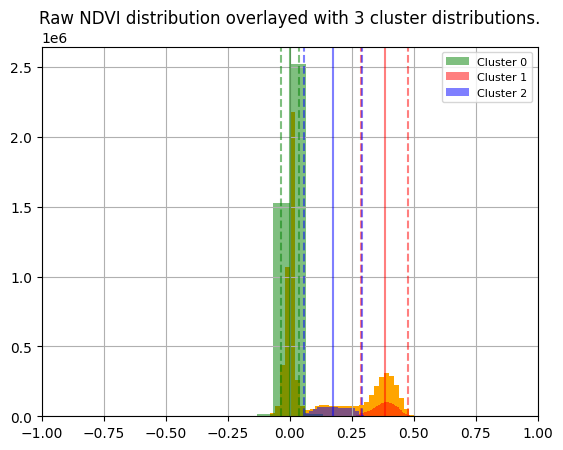

In [34]:
fig, ax = plt.subplots()

ax.hist(ndvi.reshape(-1, 1), bins=100, color='orange');
# ax.hist(ndvi.reshape(-1, 1)[kmeans_predictions.labels_ == 0], bins=30, label='Cluster 0', alpha=0.5, color='r');
# ax.hist(ndvi.reshape(-1, 1)[kmeans_predictions.labels_ == 1], bins=80, label='Cluster 1', alpha=0.5, color='g');
# ax.hist(ndvi.reshape(-1, 1)[kmeans_predictions.labels_ == 2], bins=20, label='Cluster 2', alpha=0.5, color='b');

# clusters
colors = ['g', 'r', 'b']
bins = [30, 80, 20, 60, 60]


mus, stds, bounds = [], [], []
for c in range(3):
    print(f"processing cluster {c}...")

    ax.hist(ndvi.reshape(-1, 1)[kmeans_predictions.labels_ == c], bins=bins[c], label=f'Cluster {c}', alpha=0.5, color=colors[c]);

    mu = ndvi.reshape(-1, 1)[kmeans_predictions.labels_ == c].mean()
    std = ndvi.reshape(-1, 1)[kmeans_predictions.labels_ == c].std()
    ub, lb = mu+(2*std), mu-(2*std)

    mus.append(mu)
    stds.append(std)
    bounds.append([lb, ub])

    ax.axvline(mu, alpha=0.5, color=colors[c])
    ax.axvline(lb, linestyle='--', color=colors[c], alpha=0.5)
    ax.axvline(ub, linestyle='--', color=colors[c], alpha=0.5)

ax.legend(loc='best', fontsize=8)
ax.grid()
ax.set_xlim([-1, 1])
ax.set_title("Raw NDVI distribution overlayed with 3 cluster distributions.", fontsize=12)

In [35]:
band_mapping

{'B1': 'Visible Coastal Aerosol',
 'B2': 'Visible Blue',
 'B3': 'Visible Green',
 'B4': 'Red',
 'B5': 'Near-Infrared',
 'B6': 'SWIR 1',
 'B7': 'SWIR 2',
 'B10': 'TMIR'}

In [36]:
bounds

[[-0.0362507722232251, 0.03737725839250502],
 [0.2890523859317251, 0.47548893867771314],
 [0.058571097322418844, 0.2923830487311423]]

In [37]:
axs[1].imshow(kmeans_predictions_2d)

### END OF SCRIPT